# Run the "best" models on the validation data

In [1]:
import importlib

# Load modules
import os
import sys
from time import time
from scipy import stats
import pandas as pd
import numpy as np
import plotnine
from plotnine import *
import seaborn as sns
from scipy.stats import rankdata
from time import time
from statsmodels.stats.multitest import fdrcorrection as fdr

from plydata.cat_tools import *
from y_agg import di_agg

# Load the help functions
import support.acc_funs
importlib.reload(support.acc_funs)
# from support.acc_funs import fast_auc, fast_decomp, write_fast_decomp, write_fast_inference, gen_CI
# from support.support_funs import makeifnot, decomp_var
# from support.get_cpt_annotations import cpt_desciptions

# Set directories
dir_base = os.getcwd()
dir_NSQIP = os.path.join(dir_base,'..')
dir_data = os.path.join(dir_NSQIP, 'data')
dir_raw = os.path.join(dir_data, 'raw')
dir_output = os.path.join(dir_NSQIP, 'output')
dir_figures = os.path.join(dir_NSQIP, 'figures')

# cpt_trans = cpt_desciptions()

di_outcome = {'adv':'ADV', 'aki':'AKI', 'cns':'CNS',
              'nsi':'nSSIs', 'ssi':'SSIs', 'unplan':'UPLN'}

def cvec(x):
    return np.atleast_2d(x).T

Dropping columns: oxygen_at_discharge, nutrition_at_discharge, othcdiff (>2 years of >0% missing)
Dropping columns: cnscoma, othgrafl, pulembol (<100 events in 6 years)
writing file to csv


### (1) Load data

In [2]:
# Load in the data
df = pd.read_csv(os.path.join(dir_data, 'SK_extract.csv'))
assert not df['Case Number'].duplicated().any()

# # Load an example of the year 2017
# path_ex = os.path.join(dir_raw,'ACS NSQIP 2017','acs_peds_puf17.csv')
# dat17 = pd.read_csv(path_ex, nrows=10).drop(columns='Unnamed: 0')
# dat_cn = pd.concat([pd.DataFrame({'cn':np.sort(list(df.columns)),'tt':'new'}),
#                     pd.DataFrame({'cn':np.sort(list(dat17.columns)),'tt':'old'})])
# dat_cn.to_csv(os.path.join(dir_output, 'cn_comp.csv'),index=False)

# Load the column mapper
dat_cn = pd.read_csv(os.path.join(dir_output, 'cn_comp.csv'))

# Load the original X/y data
df_X = pd.read_csv(os.path.join(dir_output,'X_imputed.csv'))
df_Y = pd.read_csv(os.path.join(dir_output,'y_agg.csv'))

# Load in the "best" outcome
best_outcome = pd.read_csv(os.path.join(dir_output, 'best_outcome.csv'))

# Load the X/y label mapper for plots
feature_mapper = pd.read_csv(os.path.join(dir_base,'feature_mapper.csv'))
di_mapper = dict(zip(feature_mapper.lvl, feature_mapper.lbl))

### (2) Process the y columns

Note that `othseshock` is ignored as its definition is too complicated and is partially collinear with `othsysep`. 3 of the 22 labels need to be manually processed.

In [3]:
cn_y = df_Y.columns.drop(['caseid','operyr','othseshock','civhg','cdarrest','death30yn'])
cn_y = list(cn_y[~cn_y.str.contains('^agg')])

mdy = '%m/%d/%Y'
# (i) Intraventricular Hemorrhage (IVH) Grade
val_Y = pd.DataFrame({'caseid':df['Case Number'].copy(),
                      'operyr':pd.to_datetime(df['Operation Date'],format=mdy).dt.strftime('%Y').astype(int),
                      'civhg':df.iloc[:,df.columns.str.contains('IVH\\sGrade')].sum(1)})

# (ii) Occurrences Cardiac Arrest Requiring CPR
cn_cdarrest = ['# of Intraop Cardiac Arrest Requiring CPR',
               '# of Postop Cardiac Arrest Requiring CPR']
val_Y['cdarrest'] = df[cn_cdarrest].sum(1)

# (iii) Death w/in 30 days of Procedure
cn_death = ['Intraop Death','Postop Death w/in 30 days of Procedure']  # No data for intraop death
val_Y['death30yn'] = np.where(df['Postop Death w/in 30 days of Procedure']=='Yes', 1, 0)

# (iv) Rename columns and subset
Ymapping = dat_cn[dat_cn.tt.isin(cn_y)].reset_index(None,True)
assert len(np.setdiff1d(cn_y, Ymapping.tt))==0
val_Y = pd.concat([val_Y,df[Ymapping.cn].copy().rename(columns=dict(zip(Ymapping.cn, Ymapping.tt)))],axis=1)


# (v) Turn "count" into "any"
val_Y[cn_y] = val_Y[cn_y].apply(lambda x: np.where(x > 0, 1, 0), axis=0)

# df.columns[df.columns.str.lower().str.contains('date')]

### (3.A) Process the X columns

`height`, `htooday`, and `weight` need to be manually encoded. `workrvu` is the only missing variable 



/home/edrysdale/miniconda3/lib/python3.7/site-packages/plotnine/scales/scale_alpha.py:70: PlotnineWarning: Using alpha for a discrete variable is not advised.


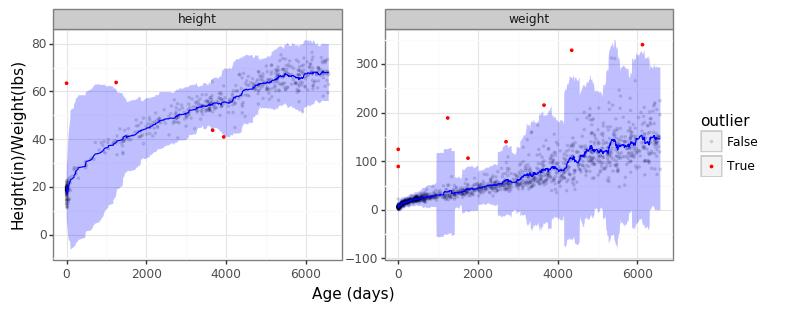

<ggplot: (8781887159305)>

In [488]:
cn_x = list(df_X.columns.drop(['caseid', 'operyr','height','htooday','weight','workrvu']))
Xmapping = dat_cn[dat_cn.tt.isin(cn_x)].reset_index(None, True)
assert len(np.setdiff1d(cn_x, Xmapping.tt))==0
dat_Xmap = df[Xmapping.cn].copy().rename(columns=dict(zip(Xmapping.cn, Xmapping.tt)))
# Compare the feature types
dat_Xmap = dat_Xmap.assign(asaclas=lambda x: np.where(x.asaclas.str.lower()=='asa not assigned','none',x.asaclas.str.lower()),
                age_days=lambda x: np.round(dat_Xmap.age_days*365.25).astype(int),
                cong_malform=lambda x: np.where(x.cong_malform == 'No','no','yes'),
                anestech=lambda x: np.where(x.anestech=='General','general','non-general'),
                prsepis=lambda x: np.where(x.prsepis == 'None', 'none', 'sepsis'),
                surgspec = lambda x: x.surgspec.str.replace('Pediatric\\s','').str.lower())
dat_Xmap.insert(0,'caseid',df['Case Number'].values)

# Booleans that need to be to str.lower()
cn_lower = ['transfus', 'hxcld', 'crf', 'casetype', 'cerebral_palsy',
            'malignancy', 'dnr', 'impcogstat', 'esovar', 'sex',
            'hemodisorder', 'asthma', 'inout', 'inotr_support',
            'lapthor', 'neuromuscdis', 'nutr_support', 'wndinf',
            'oxygen_sup', 'cpr_prior_surg', 'prvpcs', 'race',
            'seizure', 'steroid', 'struct_pulm_ab', 'acq_abnormality',
            'tracheostomy', 'transt', 'ventilat']

dat_Xmap[cn_lower] = dat_Xmap[cn_lower].apply(lambda x: x.str.lower(), axis=0)

# workrvu is not recorded in this dataset unknown
dat_Xmap['workrvu'] = np.NaN
# set ethnicity_hispanic=='no' since we have no way of knowing
dat_Xmap['ethnicity_hispanic']
cn_impute = ['lbp_disease', 'cva', 'cpneumon', 'immune_dis', 'wtloss',
             'ethnicity_hispanic', 'workrvu']
cn_X_full = np.setdiff1d(cn_x,cn_impute)

# Assign height in inches (currently cm)
dat_Xmap['height'] = df.Height / 2.54
# Assign the weight in lbs
dat_Xmap['weight'] = df.Weight * 2.20462
# Days from admission to operation
dat_Xmap['htooday'] = (pd.to_datetime(df['Operation Date'],format=mdy) - 
                       pd.to_datetime(df['Hospital Admission Date'],format=mdy)).dt.days
cn_partial = ['height', 'weight']

# REMOVE ANY HEIGHT/WEIGHT OUTLIERS
tmp_ahw = dat_Xmap[['caseid','age_days','height','weight']].copy().rename(columns={'age_days':'age'})
# Get the mean/standard deviation by deciles
tmp_ahw = tmp_ahw.melt(['caseid','age'],['height','weight'],'cn')
k = 30
tmp_roll = tmp_ahw.sort_values(['cn','age']).query('value>=0').reset_index(None, True)
tmp_roll = tmp_roll.assign(mu=tmp_roll.groupby('cn').value.rolling(k,center=True).mean().values,
                           se=tmp_roll.groupby('cn').value.rolling(2*k,center=True).std().values)
tmp_roll[['mu','se']] = tmp_roll.groupby('cn')[['mu','se']].fillna(method='bfill').fillna(method='ffill')
tmp_roll = tmp_roll.assign(tt = lambda x: np.where(x.cn=='height',3,4))
tmp_roll = tmp_roll.assign(lb=lambda x: x.mu-x.tt*x.se, ub=lambda x: x.mu+x.tt*x.se)
tmp_roll = tmp_roll.assign(outlier=lambda x: (x.value>x.ub) | (x.value<x.lb))
# Assign and replace
tmp_Xmap = dat_Xmap.merge(tmp_roll.query('outlier==True').pivot('caseid','cn','value').reset_index(),'left',['caseid'])
tmp_Xmap = tmp_Xmap.assign(height=lambda x: np.where(x.height_y.notnull(),np.NaN, x.height_x),
                           weight=lambda x: np.where(x.weight_y.notnull(),np.NaN, x.weight_x))
dat_Xmap[['height','weight']] = tmp_Xmap[['height','weight']]

plotnine.options.figure_size = (8,3)
gg_outlier = (ggplot(tmp_roll,aes(x='age',y='value',color='outlier',alpha='outlier')) + 
              theme_bw() + geom_point(size=0.5) + facet_wrap('~cn',scales='free') + 
              theme(subplots_adjust={'wspace': 0.15}) + 
              geom_line(aes(x='age',y='mu'),color='blue',inherit_aes=False) + 
              geom_ribbon(aes(x='age',ymin='lb',ymax='ub'),inherit_aes=False,color=None,fill='blue',alpha=0.25) + 
              scale_color_manual(values=['black','red']) + 
              labs(x='Age (days)',y='Height(in)/Weight(lbs)'))
gg_outlier

### (3.B) Impute the missing X features

In [491]:
from sklearn.metrics import r2_score, roc_auc_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelBinarizer
from sklearn.linear_model import Lasso, lasso_path
from glmnet import ElasticNet

# Make sure columns line up for preprocessor
Xtarget = dat_Xmap[cn_X_full].copy()
Xtrain = df_X[cn_X_full].copy()

# Get a 90/10 training/test split
nX = Xtrain.shape[0]
np.random.seed(nX)
idx_test = np.random.choice(nX, int(nX*0.1),replace=False)
idx_train = np.setdiff1d(np.arange(nX), idx_test)

# (i) We can easily impute the workrvu with the CPT
cpt_lookup = df_X.groupby(['cpt','workrvu']).size().reset_index().rename(columns={0:'n'})
tmp_rvu = dat_Xmap[['cpt']].rename_axis('idx').reset_index().merge(cpt_lookup).groupby('idx').apply(lambda x: 
            np.sum(x.workrvu*x.n)/np.sum(x.n)).reset_index().rename(columns={0:'workrvu'}).sort_values('idx').workrvu.values
dat_Xmap['workrvu'] = tmp_rvu

# (ii) Partially missing features (start with least missing one)
cn_X_full_num = ['age_days']
cn_X_full_cat = list(np.setdiff1d(cn_X_full,cn_X_full_num))

OHE = OneHotEncoder(handle_unknown='ignore')
scaler = StandardScaler()
transformer = ColumnTransformer([('cat_cols', OHE, list(Xtrain.columns.isin(cn_X_full_cat))),
                                 ('num_cols', scaler, list(Xtrain.columns.isin(cn_X_full_num)))])
enc_X = transformer.fit(Xtrain.iloc[idx_train])

for cn in cn_partial:
    print('cn: %s' % cn)
    y_train, y_test = df_X[cn].iloc[idx_train].values, df_X[cn].iloc[idx_test].values
    mdl_lasso = ElasticNet(alpha=1, n_lambda=50, n_splits=5, random_state=1,verbose=False,n_jobs=5)
    mdl_lasso.fit(X=enc_X.transform(Xtrain.iloc[idx_train]), y=y_train)
    y_pred = mdl_lasso.predict(enc_X.transform(Xtrain.iloc[idx_test]))
    r2_pred = r2_score(y_test, y_pred)
    print('R2-score: %0.3f' % r2_pred)
    dat_Xmap[cn+'2'] = np.where(dat_Xmap[cn].isnull(),mdl_lasso.predict(enc_X.transform(Xtarget)),dat_Xmap[cn])
# qq = dat_Xmap[['height','height2','age_days']].rename_axis('idx').reset_index().melt(['idx','age_days']).query('value>=0')
# plotnine.options.figure_size = (7,3.5)
# (ggplot(qq,aes(y='value',x='age_days',color='variable')) + theme_bw() + geom_point(size=0.5) + facet_wrap('~variable'))

# Assign
dat_Xmap = dat_Xmap.assign(height=lambda x: np.where(x.height.isnull(), x.height2, x.height),
                           weight=lambda x: np.where(x.weight.isnull(), x.weight2, x.weight))
dat_Xmap.drop(columns = ['height2', 'weight2'], inplace=True)

cn: height
R2-score: 0.924
cn: weight
R2-score: 0.784


In [492]:
# (iii) Impute the "fully" missing features
cn_impute_new = list(np.setdiff1d(cn_impute,['workrvu','ethnicity_hispanic']))
cn_X_full_new = list(cn_X_full) + ['height','weight','workrvu']

# Make sure columns line up for preprocessor
Xtarget_new = dat_Xmap[cn_X_full].copy()
Xtrain_new = df_X[cn_X_full].copy()

cn_num = ['age_days', 'height', 'weight', 'workrvu']
cn_cat = list(np.setdiff1d(cn_X_full_new, cn_num))

OHE = OneHotEncoder(handle_unknown='ignore')
scaler = StandardScaler()
transformer = ColumnTransformer([('cat_cols', OHE, list(Xtrain_new.columns.isin(cn_cat))),
                                 ('num_cols', scaler, list(Xtrain_new.columns.isin(cn_num)))])
enc_X = transformer.fit(Xtrain_new.iloc[idx_train])

holder_impute = df_X[cn_impute_new].iloc[idx_test].apply(lambda x: y_enc.transform(x.values).flatten(),0)
holder_impute.columns = holder_impute.columns+'_1'
for cn in cn_impute_new:
    print('cn: %s' % cn)
    y_train, y_test = df_X[cn].iloc[idx_train].values, df_X[cn].iloc[idx_test].values
    y_enc = LabelBinarizer().fit(y_train)
    y_train_bin = y_enc.transform(y_train).flatten()
    y_test_bin = y_enc.transform(y_test).flatten()
    mdl_lasso = ElasticNet(alpha=1, n_lambda=50, n_splits=5, random_state=1,verbose=False,n_jobs=5)
    mdl_lasso.fit(X=enc_X.transform(Xtrain_new.iloc[idx_train]), y=y_train_bin)
    eta_train = mdl_lasso.predict(enc_X.transform(Xtrain_new.iloc[idx_train]))
    eta_test = mdl_lasso.predict(enc_X.transform(Xtrain_new.iloc[idx_test]))
    holder_impute[cn + '_2'] = np.where(eta_test >= thresh, 1, 0)
    # Append predictions to SK data 
    eta_Xmap = mdl_lasso.predict(enc_X.transform(Xtarget_new))
    dat_Xmap[cn] = np.where(eta_Xmap >= thresh, 'yes', 'no')
    auc = roc_auc_score(y_test_bin, eta_test)
    print('auc: %0.2f' % (auc))
    
# Get the proportion (if we want to do sampling)
# dat_impute_p = (df_X[cn_impute[:-1]] == 'yes').mean(0).reset_index().rename(columns={'index':'cn',0:'p'})

di_impute = {'cpneumon':'Pneumonia','cva':'CVA','immune_dis':'ImmuneDisease',
            'lbp_disease':'LiverBiliaryPancreatic','wtloss':'WeightLoss'}
# Compare the proportions
prop_impute = pd.concat([np.mean(df_X[cn_impute_new]=='yes',0).reset_index().assign(tt='NSQIP'),
                          np.mean(dat_Xmap[cn_impute_new]=='yes',0).reset_index().assign(tt='SK')])
prop_impute = prop_impute.rename(columns={'index':'cn',0:'p'}).assign(cn=lambda x: x.cn.map(di_impute))
plotnine.options.figure_size = (4, 3)
gg_impute = (ggplot(prop_impute, aes(x='cn',y='p',color='tt')) + theme_bw() + 
             geom_point(size=2,position=position_dodge(0.5)) + 
             scale_color_discrete(name='Dataset') + 
             theme(axis_title_x=element_blank(), axis_text_x=element_text(angle=90)) + 
             labs(y='Proportion') + 
             scale_y_continuous(limits=[0,0.04]) + 
             ggtitle('100% imputed features'))
gg_impute

cn: cpneumon
auc: 0.98
cn: cva
auc: 0.96
cn: immune_dis
auc: 0.95
cn: lbp_disease
auc: 0.96
cn: wtloss
auc: 0.96


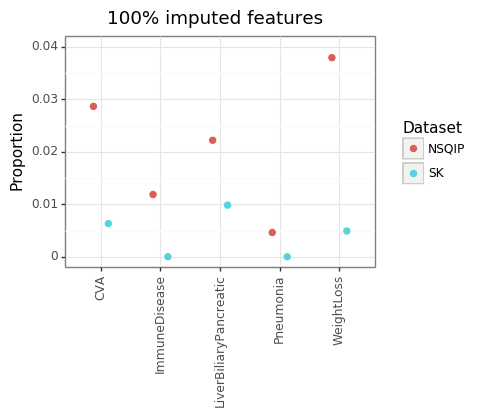

<ggplot: (8781836147133)>

### (4) Compare the CPTs

In [490]:
dat_cpt = pd.concat([dat_Xmap.cpt.value_counts(True,dropna=False).reset_index().assign(tt='SK'),
                     df_X.cpt.value_counts(True,dropna=False).reset_index().assign(tt='NSQIP')])
dat_cpt = dat_cpt.reset_index(None, True).rename(columns={'index':'cpt', 'cpt':'pct'})
dat_cpt_wide = dat_cpt.pivot('cpt','tt','pct')
assert not dat_cpt_wide.assign(check=lambda x: x.SK.notnull() & x.NSQIP.isnull()).check.any()
dat_cpt_wide = dat_cpt_wide.fillna(0).reset_index()

plotnine.options.figure_size = (5,4)
gg_cpt = (ggplot(dat_cpt_wide,aes(x='NSQIP',y='SK')) + geom_point() + 
         theme_bw() + geom_abline(slope=1,intercept=0) + 
         scale_x_continuous(limits=[0,0.15],breaks=list(np.arange(0,0.151,0.025))) + 
        scale_y_continuous(limits=[0,0.15],breaks=list(np.arange(0,0.151,0.025))))

### (5) Get risk score predictions

### (5) Compare y/X distributions

In [16]:
# (i) Individual Y's
holder_prop = []
for cn in val_Y.columns.drop(['caseid','operyr']):
    tmp_df = pd.concat([pd.DataFrame({'y':val_Y[cn].copy(),'tt':'SK'}),
                    pd.DataFrame({'y':df_Y[cn].copy(), 'tt':'NSQIP'})]).query('y>=0').reset_index(None,True)
    tmp_tbl = tmp_df.groupby(['y','tt']).size().reset_index().pivot('tt','y',0).fillna(0).astype(int)
    pval = stats.chi2_contingency(tmp_tbl.values)[1]
    tmp_prop = tmp_tbl.divide(tmp_tbl.sum(1),axis=0).reset_index().melt('tt').query('y==1').drop(columns='y')
    tmp_prop = tmp_prop.assign(outcome=cn,pval=pval)
    holder_prop.append(tmp_prop)
dist_Y = pd.concat(holder_prop).reset_index(None,True)
# Get the FDR values
dist_Y = dist_Y.merge(dist_Y.groupby('outcome').pval.max().reset_index().assign(fdr=lambda x: fdr(x.pval, alpha=0.10)[1]))
dist_Y = dist_Y.assign(outcome=lambda x: x.outcome.map(di_mapper))

# (ii) Aggregate Y's
holder_Yagg = []
for ay in di_agg:
    tmp_cn = list(np.setdiff1d(di_agg[ay],'othseshock'))
    tmp_df = pd.concat([pd.DataFrame({'y':np.where(val_Y[tmp_cn].sum(1)==0, 0, 1),'tt':'SK'}),
                    pd.DataFrame({'y':df_Y['agg_'+ay], 'tt':'NSQIP'})]).reset_index(None,True)
    tmp_tbl = tmp_df.groupby(['y','tt']).size().reset_index().pivot('tt','y',0).fillna(0).astype(int)
    pval = stats.chi2_contingency(tmp_tbl.values)[1]
    tmp_prop = tmp_tbl.divide(tmp_tbl.sum(1),axis=0).reset_index().melt('tt').query('y==1').drop(columns='y')
    tmp_prop = tmp_prop.assign(outcome=ay,pval=pval)
    holder_Yagg.append(tmp_prop)
dist_Yagg = pd.concat(holder_Yagg).reset_index(None,True)
dist_Yagg = dist_Yagg.assign(version=lambda x: x.outcome.str.replace('[^0-9]','').replace('', '1').astype(int),
                             outcome=lambda x: x.outcome.str.replace('[0-9]','').map(di_outcome))
dist_Yagg = dist_Yagg.merge(best_outcome.assign(outcome=lambda x: x.outcome.map(di_outcome)),'inner',['outcome','version'])

# (iii) Continuous X features
Xdtypes = df_X[list(cn_X_full)+cn_partial].dtypes
cn_cont = ['age_days', 'height', 'weight']
tmp1 = dat_Xmap[['caseid']+cn_cont].melt('caseid',None,'cn').query('value>=0').assign(tt='SK')
tmp2 = df_X[['caseid']+cn_cont].melt('caseid',None,'cn').assign(tt='NSQIP')
dat_cont = pd.concat([tmp1, tmp2]).reset_index(None,True)
del tmp1, tmp2

for cn in cn_cont:
    tmp_test = stats.mannwhitneyu(dat_cont.query('cn==@cn & tt=="SK"').value.values,
                   dat_cont.query('cn==@cn & tt=="NSQIP"').value.values)
    print('cn: %s, pvalue: %0.6f' % (cn, tmp_test.pvalue))
    
# (iv) Categorical X features
holder_cat = []
for cn in list(np.setdiff1d(cn_X_full,cn_cont+['cpt'])):
    tmp_df = pd.concat([pd.DataFrame({'y':dat_Xmap[cn].copy(),'tt':'SK'}),
                    pd.DataFrame({'y':df_X[cn].copy(), 'tt':'NSQIP'})]).reset_index(None,True)
    tmp_tbl = tmp_df.groupby(['y','tt']).size().reset_index().pivot('tt','y',0).fillna(0).astype(int)
    pval = stats.chi2_contingency(tmp_tbl.values)[1]
    tmp_prop = tmp_tbl.divide(tmp_tbl.sum(1),axis=0).reset_index().melt('tt').assign(outcome=cn,pval=pval)
    holder_cat.append(tmp_prop)
dist_cat = pd.concat(holder_cat).reset_index(None,True)
dist_cat = dist_cat.merge(dist_cat.groupby('outcome').pval.max().reset_index().assign(fdr=lambda x: fdr(x.pval, alpha=0.10)[1]))
ncat = dist_cat.groupby('outcome').size().reset_index().rename(columns={0:'n'})


cn: age_days, pvalue: 0.000817
cn: height, pvalue: 0.000000
cn: weight, pvalue: 0.000299


In [379]:
1450 / 6

241.66666666666666

### (X) Figures

In [18]:
# (i) Visualize distribution of the labels

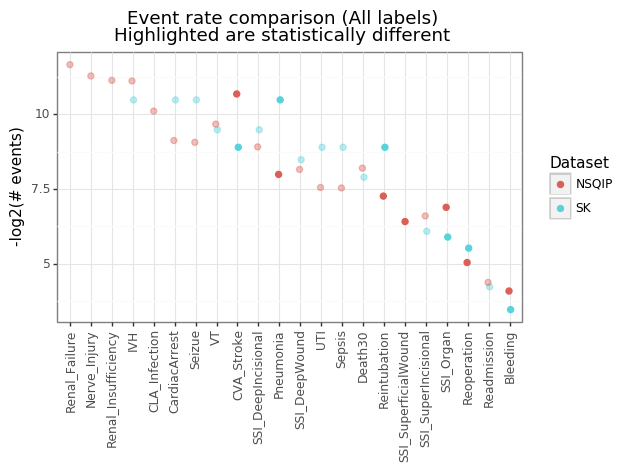

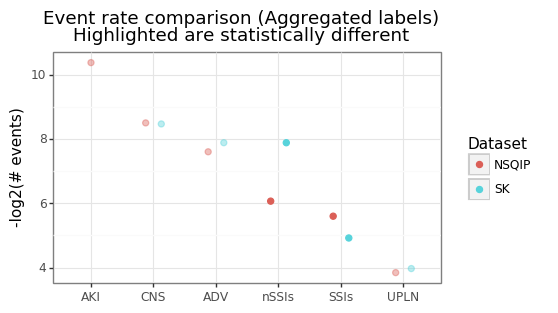

In [19]:
w, h = 6, 3.5
plotnine.options.figure_size = (w, h)
posd = position_dodge(0.15)
tmp = dist_Y.query('value>0').assign(outcome=lambda x: cat_reorder(x.outcome,x.value))
gg_Yagg = (ggplot(tmp, aes(x='outcome',y='-np.log2(value)',color='tt',alpha='pval<0.1')) + 
           theme_bw() + geom_point(position=posd,size=2) + 
           scale_color_discrete(name='Dataset') + 
           labs(y='-log2(# events)') + 
           ggtitle('Event rate comparison (All labels)\nHighlighted are statistically different') + 
           theme(axis_title_x=element_blank(), axis_text_x=element_text(angle=90)) + 
           scale_alpha_manual(values=[0.4,1.0]) + 
           guides(alpha=False))
print(gg_Yagg)

w, h = 5, 3
plotnine.options.figure_size = (w, h)
posd = position_dodge(0.5)
tmp = dist_Yagg.query('value>0').assign(outcome=lambda x: cat_reorder(x.outcome,x.value))
gg_Yagg = (ggplot(tmp, aes(x='outcome',y='-np.log2(value)',color='tt',alpha='pval<0.1')) + 
           theme_bw() + geom_point(position=posd,size=2) + 
           scale_color_discrete(name='Dataset') + 
           labs(y='-log2(# events)') + 
           ggtitle('Event rate comparison (Aggregated labels)\nHighlighted are statistically different') + 
           theme(axis_title_x=element_blank()) + 
           scale_alpha_manual(values=[0.4,1.0]) + 
           guides(alpha=False))
print(gg_Yagg)

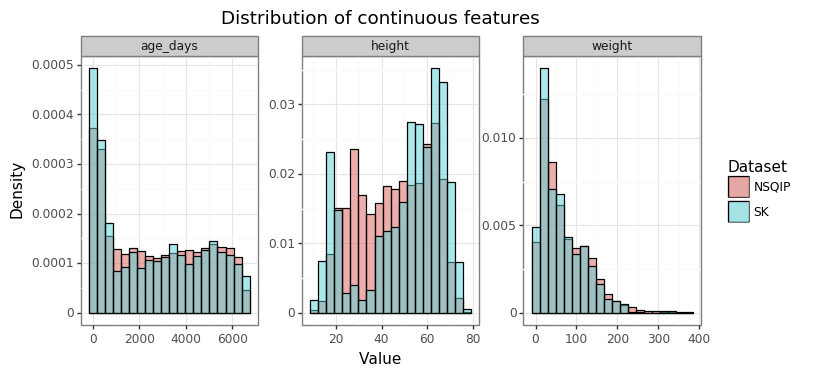

<ggplot: (8781897497945)>

In [20]:
w, h = 8, 3.5
plotnine.options.figure_size = (w, h)

gg_X_cont = (ggplot(dat_cont.groupby(['tt','cn']).sample(n=10000,replace=True,random_state=1)) + theme_bw() + 
             geom_histogram(aes(x='value',y='stat(density)',fill='tt'),
                            alpha=0.50,color='black', position="identity",bins=20) + 
             facet_wrap('~cn',scales='free') + 
             theme(subplots_adjust={'wspace': 0.25}) + 
             labs(x='Value',y='Density') + 
             scale_fill_discrete(name='Dataset') + 
             ggtitle('Distribution of continuous features'))
gg_X_cont

/home/edrysdale/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


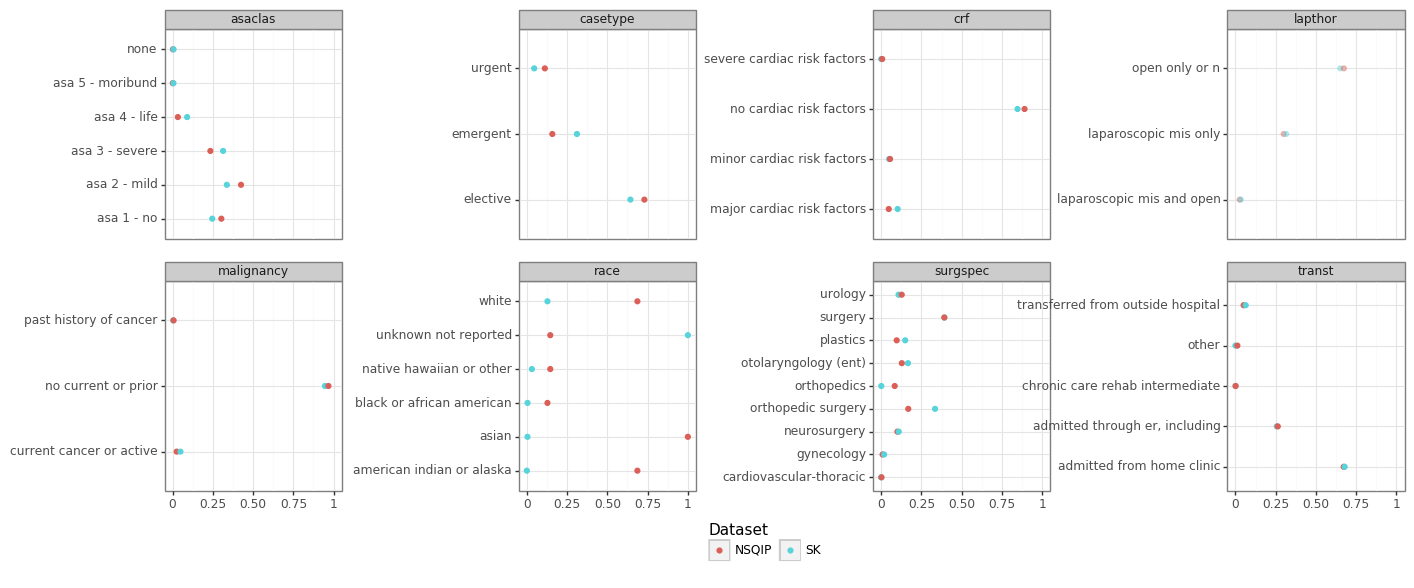

<ggplot: (8781897413285)>

In [21]:
w, h = 16, 6
plotnine.options.figure_size = (w, h)

tmp = dist_cat[dist_cat.outcome.isin(ncat.query('n>4').outcome)]
tmp['y'] = tmp.y.str.split('\\s|\\/',5,True).iloc[:,0:4].fillna('').apply(lambda x: ' '.join(x), 1).str.strip()
(ggplot(tmp,aes(x='value',y='y',color='tt',alpha='fdr<0.1')) + 
          theme_bw() + geom_point(position=position_dodge2(0.0)) + 
          facet_wrap('~outcome',scales='free_y',nrow=2) + 
          scale_color_discrete(name='Dataset') + 
          theme(axis_title=element_blank(),legend_position='bottom',
                subplots_adjust={'hspace': 0.2, 'wspace': 1}) + 
          scale_alpha_manual(values=[0.4,1.0]) + 
          guides(alpha=False))

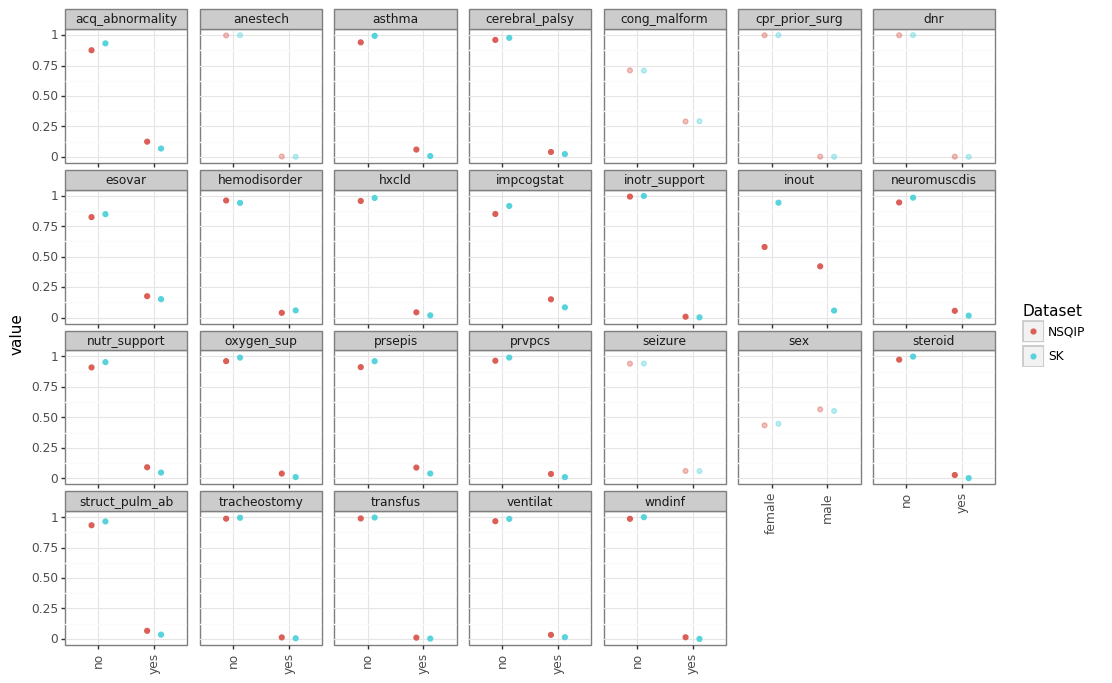

<ggplot: (8781833629477)>

In [365]:
w, h = 12, 8
plotnine.options.figure_size = (w, h)

tmp = dist_cat[dist_cat.outcome.isin(ncat.query('n==4').outcome)]
gg_cat = (ggplot(tmp,aes(x='y',y='value',color='tt',alpha='fdr<0.1')) + 
          theme_bw() + geom_point(position=position_dodge(0.5)) + 
          facet_wrap('~outcome',scales='free_x',ncol=7) + 
          scale_color_discrete(name='Dataset') + 
          theme(axis_title_x=element_blank(),axis_text_x=element_text(angle=90),
                subplots_adjust={'hspace': 0.2, 'wspace': 0.1}) + 
          scale_alpha_manual(values=[0.4,1.0]) + 
           guides(alpha=False))
gg_cat